<a href="https://colab.research.google.com/github/AvrodeepPal/LSTM_Avro_Riju_Arya/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
13/13 - 7s - 546ms/step - loss: 0.0106 - val_loss: 0.0722
Epoch 2/100
13/13 - 1s - 61ms/step - loss: 0.0039 - val_loss: 0.0355
Epoch 3/100
13/13 - 1s - 64ms/step - loss: 8.5591e-04 - val_loss: 7.7558e-04
Epoch 4/100
13/13 - 1s - 57ms/step - loss: 2.6839e-04 - val_loss: 0.0014
Epoch 5/100
13/13 - 1s - 54ms/step - loss: 2.4144e-04 - val_loss: 0.0048
Epoch 6/100
13/13 - 1s - 56ms/step - loss: 1.8326e-04 - val_loss: 0.0051
Epoch 7/100
13/13 - 1s - 70ms/step - loss: 1.9045e-04 - val_loss: 0.0057
Epoch 8/100
13/13 - 1s - 48ms/step - loss: 1.7120e-04 - val_loss: 0.0039
Epoch 9/100
13/13 - 1s - 47ms/step - loss: 1.9819e-04 - val_loss: 0.0059
Epoch 10/100
13/13 - 1s - 47ms/step - loss: 1.7731e-04 - val_loss: 0.0053
Epoch 11/100
13/13 - 1s - 48ms/step - loss: 1.5020e-04 - val_loss: 0.0060
Epoch 12/100
13/13 - 0s - 28ms/step - loss: 1.7049e-04 - val_loss: 0.0070
Epoch 13/100
13/13 - 1s - 46ms/step - loss: 1.7220e-04 - val_loss: 0.0066
Epoch 14/100
13/13 - 0s - 28ms/step - loss: 1.3176

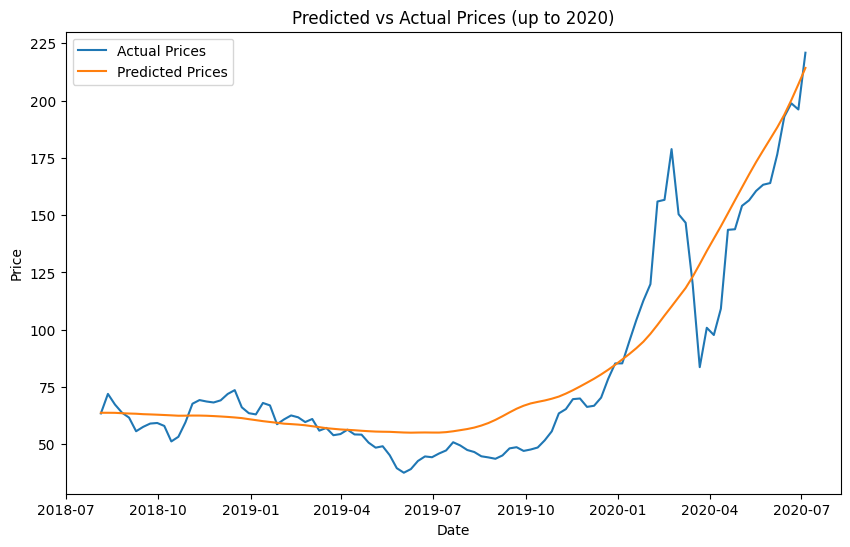

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('TSLA.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter data to include only up to 2020 to avoid covid effect(noise)
data = data[data.index <= '2020-12-31']

# Resample the data to weekly frequency, using the mean of the daily adjusted close prices
data = data.resample('W').mean()

# Perform seasonal decomposition
result = seasonal_decompose(data['Adj Close'], model='multiplicative', period=52)
data['trend'] = result.trend
data['seasonal'] = result.seasonal
data['residual'] = result.resid

# Drop NaN values created by the decomposition
data.dropna(inplace=True)

# Scale data
scaler = MinMaxScaler()
scaled_trend = scaler.fit_transform(data['trend'].values.reshape(-1, 1))
scaled_seasonal = scaler.fit_transform(data['seasonal'].values.reshape(-1, 1))
scaled_residual = scaler.fit_transform(data['residual'].values.reshape(-1, 1))

# Split the data
train_size = len(scaled_trend) - 104  # Last 104 weeks for testing
train_trend, test_trend = scaled_trend[:train_size], scaled_trend[train_size:]
train_seasonal, test_seasonal = scaled_seasonal[:train_size], scaled_seasonal[train_size:]
train_residual, test_residual = scaled_residual[:train_size], scaled_residual[train_size:]

# Prepare dataset
n_input = 3  # number of previous weeks to use for prediction
n_output = 1  # predicting the next week

def create_dataset(data, n_input, n_output):
    X, y = [], []
    for i in range(len(data) - n_input - n_output + 1):
        X.append(data[i:i+n_input])
        y.append(data[i+n_input:i+n_input+n_output])
    return np.array(X), np.array(y)

X_train_trend, y_train_trend = create_dataset(train_trend, n_input, n_output)
X_test_trend, y_test_trend = create_dataset(test_trend, n_input, n_output)

X_train_seasonal, y_train_seasonal = create_dataset(train_seasonal, n_input, n_output)
X_test_seasonal, y_test_seasonal = create_dataset(test_seasonal, n_input, n_output)

X_train_residual, y_train_residual = create_dataset(train_residual, n_input, n_output)
X_test_residual, y_test_residual = create_dataset(test_residual, n_input, n_output)

#  y_train and y_test are reshaped correctly for inverse scaling
y_train_trend = y_train_trend.reshape(-1, 1)
y_test_trend = y_test_trend.reshape(-1, 1)

y_train_seasonal = y_train_seasonal.reshape(-1, 1)
y_test_seasonal = y_test_seasonal.reshape(-1, 1)

y_train_residual = y_train_residual.reshape(-1, 1)
y_test_residual = y_test_residual.reshape(-1, 1)

# Define LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(n_input, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(LSTM(150, return_sequences=True))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(LSTM(150))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))
    model.add(Dense(n_output))
    model.compile(optimizer=Nadam(), loss='mse')
    return model


# Train models for each component
model_trend = create_lstm_model()
history_trend = model_trend.fit(X_train_trend, y_train_trend, epochs=100, validation_data=(X_test_trend, y_test_trend),  verbose=2)

model_seasonal = create_lstm_model()
history_seasonal = model_seasonal.fit(X_train_seasonal, y_train_seasonal, epochs=100, validation_data=(X_test_seasonal, y_test_seasonal), verbose=2)

model_residual = create_lstm_model()
history_residual = model_residual.fit(X_train_residual, y_train_residual, epochs=100, validation_data=(X_test_residual, y_test_residual),verbose=2)

# Make predictions
train_predictions_trend = model_trend.predict(X_train_trend)
test_predictions_trend = model_trend.predict(X_test_trend)

train_predictions_seasonal = model_seasonal.predict(X_train_seasonal)
test_predictions_seasonal = model_seasonal.predict(X_test_seasonal)

train_predictions_residual = model_residual.predict(X_train_residual)
test_predictions_residual = model_residual.predict(X_test_residual)

# Inverse transform the predictions and actual values to original scale
trend_scaler = MinMaxScaler()
seasonal_scaler = MinMaxScaler()
residual_scaler = MinMaxScaler()


scaled_trend = trend_scaler.fit_transform(data['trend'].values.reshape(-1, 1))
scaled_seasonal = seasonal_scaler.fit_transform(data['seasonal'].values.reshape(-1, 1))
scaled_residual = residual_scaler.fit_transform(data['residual'].values.reshape(-1, 1))

train_predictions_trend = trend_scaler.inverse_transform(train_predictions_trend)
y_train_trend_inv = trend_scaler.inverse_transform(y_train_trend)
test_predictions_trend = trend_scaler.inverse_transform(test_predictions_trend)
y_test_trend_inv = trend_scaler.inverse_transform(y_test_trend)

train_predictions_seasonal = seasonal_scaler.inverse_transform(train_predictions_seasonal)
y_train_seasonal_inv = seasonal_scaler.inverse_transform(y_train_seasonal)
test_predictions_seasonal = seasonal_scaler.inverse_transform(test_predictions_seasonal)
y_test_seasonal_inv = seasonal_scaler.inverse_transform(y_test_seasonal)

train_predictions_residual = residual_scaler.inverse_transform(train_predictions_residual)
y_train_residual_inv = residual_scaler.inverse_transform(y_train_residual)
test_predictions_residual = residual_scaler.inverse_transform(test_predictions_residual)
y_test_residual_inv = residual_scaler.inverse_transform(y_test_residual)

# Combine the components to get final predictions
train_predictions = train_predictions_trend + train_predictions_seasonal + train_predictions_residual
test_predictions = test_predictions_trend + test_predictions_seasonal + test_predictions_residual

# Plot predicted vs actual values for the test set
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test_trend_inv):], data['Adj Close'][-len(y_test_trend_inv):], label='Actual Prices')
plt.plot(data.index[-len(y_test_trend_inv):], test_predictions, label='Predicted Prices')
plt.title('Predicted vs Actual Prices (up to 2020)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

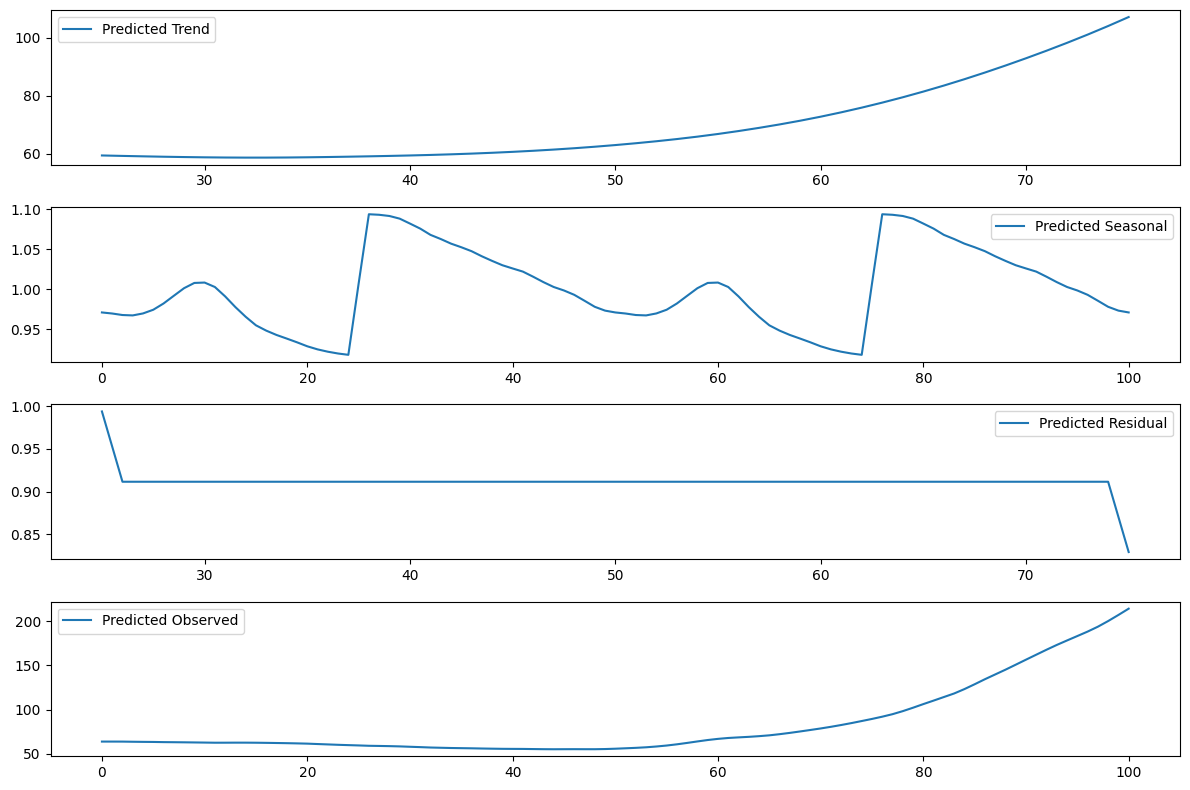

Mean Squared Error Loss: 468.1931166195752


In [6]:
# Calculate Seasonal Decomposition for Predictions
# Use a period that is less than or equal to half the length of test_predictions
result_pred = seasonal_decompose(test_predictions.flatten(), model='multiplicative', period=50)

# Plot the decomposed components of predictions
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result_pred.trend, label='Predicted Trend')
plt.legend()
plt.subplot(412)
plt.plot(result_pred.seasonal, label='Predicted Seasonal')
plt.legend()
plt.subplot(413)
plt.plot(result_pred.resid, label='Predicted Residual')
plt.legend()
plt.subplot(414)
plt.plot(result_pred.observed, label='Predicted Observed')
plt.legend()
plt.tight_layout()
plt.show()

# Import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error

# Calculate Loss Function (Mean Squared Error for example)
loss = mean_squared_error(y_test_trend_inv, test_predictions)
print(f"Mean Squared Error Loss: {loss}")

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_trend_inv, test_predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_trend_inv, test_predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate Total Errors as a percentage
total_errors = np.sum(np.abs(y_test_trend_inv - test_predictions)) / np.sum(np.abs(y_test_trend_inv)) * 100
print(f"Total Errors: {total_errors:.2f}%")

# Calculate Accuracy as (100 - Total Errors)
accuracy = 100 - total_errors
print(f"Accuracy: {accuracy:.2f}%")


Mean Absolute Error (MAE): 12.056329347706008
Mean Squared Error (MSE): 468.1931166195752
Root Mean Squared Error (RMSE): 21.637770601879836
Total Errors: 12.75%
Accuracy: 87.25%
